In [1]:
import numpy as np
import io
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import pandas as pd 
import math

Importing Test File

In [2]:
Xtestd = np.genfromtxt("x_test.csv", dtype=float, delimiter=',', skip_header=1) # i have not scaled this to (0,1) by dividing it by 255
 # The final data needs to be scaled from 0 to 1 (if you change this, then do not scale the training data either)
type(Xtestd) # this is a nd array
Xtestd.shape

(1266, 3072)

In [3]:
Xte = []
for i in range(1266):
    frame = []
    for j in range(3):
        frame.append(np.reshape((Xtestd[i,1024*j:1024*(j+1)]),(32,32)))
    framef = np.concatenate((frame[0], frame[1], frame[2]), axis = 1)
    Xte.append(framef)
Xte = np.asarray(Xte)
Xte.shape

(1266, 32, 96)

In [6]:
Xte[0]

array([[206., 215., 202., ..., 204., 208., 205.],
       [201., 211., 203., ..., 205., 207., 202.],
       [208., 215., 205., ..., 205., 206., 202.],
       ...,
       [210., 208., 208., ..., 208., 207., 206.],
       [211., 211., 209., ..., 203., 206., 207.],
       [212., 211., 211., ..., 205., 205., 207.]])

In [4]:
for k in range(len(Xte)):
    for i in range(32):
        for j in range(96):
            if Xte[k][i][j]>160:
                Xte[k][i][j]=255

I am cleaning the Test file by setting every test value above 160 as 255

In [8]:
Xte[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [5]:
training = imageio.v3.imread("train.gif")

In [6]:
frame_tr = training.mean(3) # i haven't scaled it to (0,1)
frame_tr.shape
# we do this because it is a grayscale image so r=g=b

(16000, 32, 32)

x_train_df is one of the dataset of 3 frames concatanated

In [11]:
eda_df = pd.read_csv("x_train_df.csv")
eda_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,242.0,236.0,230.0,237.0,237.0,242.0,242.0,219.0,229.0,234.0,...,196.0,206.0,213.0,213.0,207.0,201.0,199.0,205.0,206.0,196.0
1,244.0,237.0,233.0,239.0,233.0,236.0,238.0,221.0,216.0,226.0,...,200.0,207.0,213.0,213.0,209.0,204.0,203.0,208.0,208.0,198.0
2,243.0,238.0,235.0,224.0,224.0,221.0,227.0,216.0,212.0,223.0,...,203.0,209.0,214.0,214.0,210.0,203.0,198.0,201.0,197.0,194.0
3,237.0,231.0,232.0,223.0,225.0,222.0,224.0,217.0,214.0,224.0,...,200.0,207.0,213.0,215.0,210.0,203.0,197.0,200.0,197.0,197.0
4,209.0,214.0,217.0,216.0,219.0,215.0,217.0,204.0,206.0,211.0,...,199.0,206.0,211.0,210.0,207.0,203.0,199.0,203.0,202.0,202.0


In [12]:
row = eda_df.iloc[4] # Taking any one of the dataset of 3 frames
df = pd.DataFrame(row)

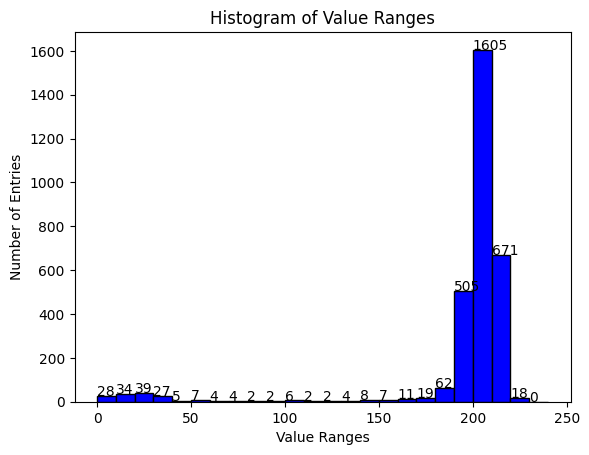

In [13]:
bins = [10*x for x in range(25)] 

# Using plt.hist to create a histogram
counts, edges, _ = plt.hist(df[4], bins=bins, color='blue', edgecolor='black')

plt.xlabel('Value Ranges')
plt.ylabel('Number of Entries')
plt.title('Histogram of Value Ranges')

for count, edge in zip(counts, edges[1:]):
    plt.text(edge - 10, count + 0.1, str(int(count)), color='black')


plt.show()


In [14]:
# from this histogram i decided my threshold

Cleaning the training data

In [7]:
for k in range(len(frame_tr)):
    for i in range(32):
        for j in range(32):
            if frame_tr[k][i][j]>160:
                frame_tr[k][i][j]=255

In [16]:
frame_tr[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [149., 255., 255., ..., 255., 255., 255.]])

## Data Cleaning

In [8]:
def calc_dist(a, centre_list):
    """This function is used to calculate the distance between 2 centres"""
    x1 = centre_list[a-1][0]
    x2 = centre_list[a][0]
    y1 = centre_list[a-1][1]
    y2 = centre_list[a][1]

    distance = (((x2-x1)**2) + ((y2-y1)**2))**0.5

    return distance

In [9]:
centre_list = [] # this is a list of tuples of the centre of the ball in ecery frame
dist_list = []  # Distance between centres of in 2 consecutive frames
flick_list = []  # List of the flickering frames

for k in range(frame_tr.shape[0]):
    pos_element = []  # list of tuples of coordinates of pixels of the ball
    for i in range(frame_tr.shape[1]):
        for j in range(frame_tr.shape[2]):
            if frame_tr[k][i][j] < 80:  # 80 so that i choose all the pixels near the centre of the ball
                pos_element.append((i,j)) # tuple of position is appended

    pos_array = np.array(pos_element)
    x_centre = math.floor(np.mean(pos_array[:,0]))
    y_centre = math.floor(np.mean(pos_array[:,1]))

    centre_list.append((x_centre,y_centre))


for k in range(1,frame_tr.shape[0]):
    dist_list.append(calc_dist(k,centre_list))


for a in range(len(dist_list)):
    if dist_list[a] > 10:
        flick_list.append(a+1)  # we append a+1 because if the distance at ath index is > 10 then it is the distance between a and (a+1)th index's centre so the a+1 frame is selected as flicker


In [19]:
print(len(flick_list))
flick_list

1478


[3,
 4,
 7,
 9,
 25,
 26,
 34,
 35,
 48,
 49,
 66,
 68,
 73,
 74,
 126,
 127,
 133,
 134,
 136,
 137,
 170,
 171,
 174,
 176,
 190,
 191,
 218,
 219,
 237,
 238,
 279,
 280,
 347,
 348,
 402,
 403,
 483,
 484,
 492,
 493,
 502,
 503,
 638,
 639,
 645,
 646,
 668,
 669,
 672,
 673,
 689,
 690,
 692,
 693,
 701,
 702,
 705,
 706,
 762,
 763,
 814,
 815,
 826,
 827,
 829,
 830,
 860,
 861,
 898,
 899,
 955,
 956,
 975,
 977,
 1048,
 1049,
 1060,
 1061,
 1084,
 1085,
 1094,
 1095,
 1106,
 1107,
 1135,
 1136,
 1171,
 1172,
 1188,
 1189,
 1196,
 1198,
 1200,
 1201,
 1206,
 1207,
 1254,
 1255,
 1256,
 1257,
 1294,
 1295,
 1296,
 1297,
 1312,
 1313,
 1321,
 1322,
 1367,
 1368,
 1379,
 1380,
 1430,
 1431,
 1437,
 1438,
 1476,
 1477,
 1479,
 1480,
 1496,
 1497,
 1517,
 1519,
 1532,
 1533,
 1545,
 1546,
 1558,
 1559,
 1605,
 1606,
 1615,
 1616,
 1646,
 1647,
 1649,
 1650,
 1687,
 1688,
 1695,
 1696,
 1716,
 1717,
 1748,
 1749,
 1771,
 1772,
 1783,
 1784,
 1819,
 1820,
 1853,
 1854,
 1899,
 1901,


In [10]:
q = 0
for p in range(0, len(flick_list)-1,2):
    if flick_list[p] + 1 != flick_list[p+1]:
        q += 1
        dif = flick_list[p+1] - flick_list[p]
        if dif !=2:
            print(dif)
            print(p)
q

4
1002


33

From my eda i am able to figure out that mostly the flickers last for 1 frame but in some cases they last for 2 and in one case they last for 4 frames

In [21]:
abx = pd.DataFrame(flick_list)
abx.to_csv("flick_list.csv", index=False)
# i created a csv file to look at the index of all the frames more clearly in an excel sheet

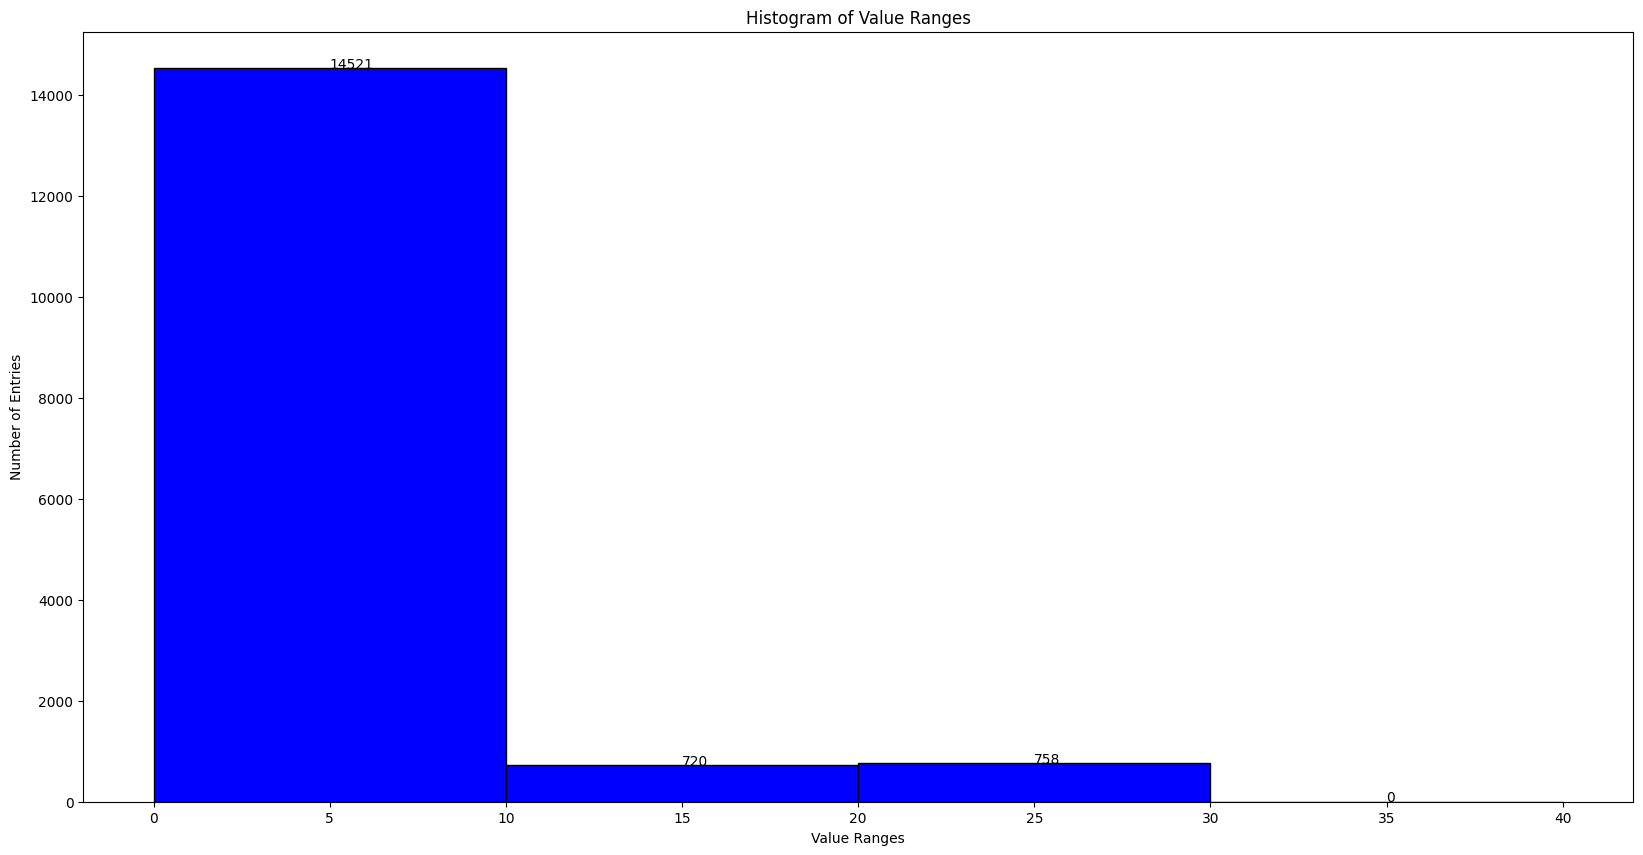

In [11]:
bins = [10*x for x in range(5)] 

plt.figure(figsize=(20,10))
# Using plt.hist to create a histogram
counts, edges, _ = plt.hist(dist_list, bins=bins, color='blue', edgecolor='black')

plt.xticks(np.arange(min(edges), max(edges)+1, 5))

plt.xlabel('Value Ranges')
plt.ylabel('Number of Entries')
plt.title('Histogram of Value Ranges')

for count, edge in zip(counts, edges[1:]):
    plt.text(edge - 5, count + 0.1, str(int(count)), color='black')

plt.show()

In [23]:
# So any distance above 10 must be a flicker

In [12]:
# Creating the data to train on
final_train = frame_tr
to_delete = [] # list of indices to be deleted
for t in range(0, len(flick_list), 2):
    if flick_list[t] + 1 == flick_list[t+1]:
      a = flick_list[t]
      for i in range(32):
        for j in range(32):
            frame_tr[a][i][j] = (frame_tr[a+1][i][j] + frame_tr[a-1][i][j])/2
    
    elif flick_list[t] + 2 == flick_list[t+1]:
      to_delete.append(flick_list[t])
      to_delete.append(flick_list[t]+1)
      # final_train = np.delete(final_train,[flick_list[p], flick_list[p]+1], axis=0)
    
    elif flick_list[t] + 4 == flick_list[t+1]:
      to_delete.append(flick_list[t])
      to_delete.append(flick_list[t]+1)
      to_delete.append(flick_list[t]+2)
      to_delete.append(flick_list[t]+3)
      
      # final_train = np.delete(final_train,[flick_list[p], flick_list[p]+1, flick_list[p]+2, flick_list[p]+3], axis=0)
  
print(len(to_delete))
to_delete

68


[7,
 8,
 66,
 67,
 174,
 175,
 975,
 976,
 1196,
 1197,
 1517,
 1518,
 1899,
 1900,
 2819,
 2820,
 3080,
 3081,
 3356,
 3357,
 4039,
 4040,
 4674,
 4675,
 4894,
 4895,
 4988,
 4989,
 5852,
 5853,
 6295,
 6296,
 6747,
 6748,
 6864,
 6865,
 7051,
 7052,
 7194,
 7195,
 7383,
 7384,
 7633,
 7634,
 7684,
 7685,
 8433,
 8434,
 9488,
 9489,
 10226,
 10227,
 10627,
 10628,
 10629,
 10630,
 11875,
 11876,
 12359,
 12360,
 13320,
 13321,
 14482,
 14483,
 14973,
 14974,
 15518,
 15519]

Here wherever the flicker lasts for 1 frame i replaced that frame with the average value of the frame vefore it and the frame next to it and for rest of the flickers i am deleting those frames

In [13]:
final_train = np.delete(final_train, to_delete, axis=0)
final_train.shape

(15932, 32, 32)

In [26]:
input_images = []
for i in range(len(final_train)):
    img = Image.fromarray((final_train[i]).astype(np.uint8), 'L')
    input_images.append(img)

# Save the images as a GIF
input_path = "input.gif"
imageio.mimsave(input_path, input_images, duration=0.01)

## THIS GIF IS NOT NOISY

## MODEL AND PREDICTION


In [14]:
ytr = final_train[6:, :]
Xtr = []
for i in range(ytr.shape[0]):
    frame = np.concatenate((final_train[i], final_train[i+1], final_train[i+2]), axis = 1)
    Xtr.append(frame)
Xtr = np.asarray(Xtr)
print(Xtr.shape)
ytr.shape

(15926, 32, 96)


(15926, 32, 32)

In [15]:
Xtr = np.reshape(Xtr, (Xtr.shape[0], Xtr.shape[1]*Xtr.shape[2]))
ytr = np.reshape(ytr, (ytr.shape[0], ytr.shape[1]*ytr.shape[2]))
Xte = np.reshape(Xte, (Xte.shape[0], Xte.shape[1]*Xte.shape[2]))

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
my_model = RandomForestRegressor(n_estimators=45)

In [18]:
my_model.fit(Xtr,ytr)

RandomForestRegressor(n_estimators=45)

In [29]:
from xgboost import XGBRegressor

In [30]:
my_model = XGBRegressor(n_estimators= 15, learning_rate = 0.1, max_depth=5)

In [31]:
my_model.fit(Xtr,ytr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=15, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
ypr = my_model.predict(Xte)
print(ypr.shape)
# for i in range(len(ypr)):
#     for j in range(1024):
#         if ypr[i][j]>245:
#             ypr[i][j]=255


(1266, 1024)


Here if the part in uncommented we will make all the light frames as part of white background

In [33]:
ypr[0]

array([249.84836, 251.82466, 252.71161, ..., 253.25972, 253.25972,
       253.25972], dtype=float32)

In [20]:
ypr = ypr/255 # To scale it for the test

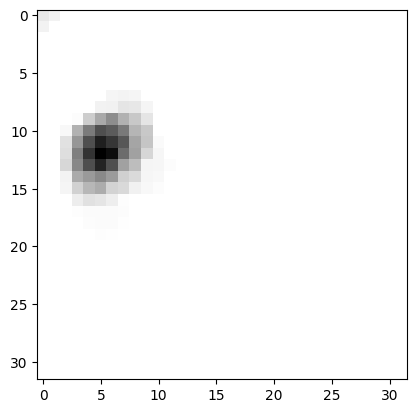

In [21]:
ypred=ypr[111].reshape(32,32)
plt.imshow(ypred,cmap='gray')
# One of the example outputs

## Uploading the predictions 

In [22]:
column_names = ["Id"]
for i in range(32):
    for j in range(32):
        col_name = f'frame_{3}_row_{i}_col_{j}'
        column_names.append(col_name)

In [23]:
ypr = np.concatenate([np.arange(1, 1+len(ypr)).reshape(-1,1), ypr], axis=1)
ypr.shape

(1266, 1025)

In [24]:
df = pd.DataFrame(ypr, columns=column_names)
df["Id"] = df["Id"].astype(int)
df.to_csv("y_test[RF_denoised_with_Xte_smooth_nothresh].csv", index=False)